In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.api as sm
import datetime as dt

import warnings
warnings.filterwarnings('ignore')

### 1. IMPORTING ASSET AND MARKET DATA

In [3]:
industry_raw = pd.read_excel('Industry_Portfolios.xlsx')
industry_raw = industry_raw.set_index('Date')
industry_raw.head(2)

,NoDur,Durbl,Manuf,Enrgy,HiTec,Telcm,Shops,Hlth,Utils,Other
Date,,,,,,,,,,
200401,0.06,-1.07,-0.62,0.44,4.53,1.41,0.45,3.09,1.92,2.88
200402,4.25,-0.07,1.95,4.69,-2.92,-0.52,6.09,0.89,2.07,2.16


In [4]:
industry_raw.index = pd.to_datetime(industry_raw.index)
industry_raw.index = industry_raw.index.to_period('M')
industry_raw.head(2)

,NoDur,Durbl,Manuf,Enrgy,HiTec,Telcm,Shops,Hlth,Utils,Other
Date,,,,,,,,,,
1970-01,0.06,-1.07,-0.62,0.44,4.53,1.41,0.45,3.09,1.92,2.88
1970-01,4.25,-0.07,1.95,4.69,-2.92,-0.52,6.09,0.89,2.07,2.16


In [5]:
def ret_vol_calc(returns, mode='arithmetic', periods=12):
    """
    Calculate return and volatility statistics.
    
    Parameters:
    - returns (pd.Series or pd.DataFrame): Either a Series or a DataFrame of return columns.
    - mode (str): 'arithmetic' (for percentage change) or 'geometric' (for log return).
    - periods (int): The number of periods in a year (e.g., 12 for monthly, 252 for daily).
    
    Returns:
    pd.DataFrame: A DataFrame with calculated return, annualized return, standard deviation, 
                  annualized standard deviation, and CAGR.
    """
    
    # Check for return as Series or DataFrame and calculate accordingly
    if isinstance(returns, pd.Series) or isinstance(returns, pd.DataFrame):
        
        # Calculate the mean return and standard deviation
        if mode == 'arithmetic':
            mean_ret = returns.mean()
            std = returns.std()
        elif mode == 'geometric':
            mean_ret = np.log(1 + returns).mean()
            std = np.log(1 + returns).std()
        else:
            raise ValueError("Invalid mode. Choose either 'arithmetic' or 'geometric'.")
        
        # Annualization
        annualized_ret = mean_ret * periods
        annualized_std = std * np.sqrt(periods)
        
        # Calculate CAGR
        observations = len(returns)
        if mode == 'arithmetic':
            cum_ret = (1 + returns).prod()
            CAGR = cum_ret ** (periods / observations) - 1
        else:
            cum_ret = np.exp(np.log(1 + returns).cumsum().iloc[-1])
            CAGR = cum_ret ** (periods / observations) - 1
        
        # Combine the results into a DataFrame
        results = pd.DataFrame({
            'Return': mean_ret.round(4),
            'Annualized Return': annualized_ret.round(4),
            'Standard Deviation': std.round(4),
            'Annualized Standard Deviation': annualized_std.round(4),
            'CAGR': CAGR.round(4)
        })
        
        return results.T if isinstance(returns, pd.Series) else results
    
    else:
        raise TypeError("The returns input should be either a Series or DataFrame.")

In [6]:
industry_ret_sd =  ret_vol_calc(industry_raw/100, mode='arithmetic', periods=12)
industry_ret_sd

,Return,Annualized Return,Standard Deviation,Annualized Standard Deviation,CAGR
NoDur,0.0090,0.1083,0.0335,0.1159,0.1065
Durbl,0.0073,0.0880,0.0836,0.2897,0.0478
Manuf,0.0101,0.1215,0.0531,0.1840,0.1095
Enrgy,0.0123,0.1477,0.0608,0.2107,0.1330
HiTec,0.0077,0.0919,0.0538,0.1864,0.0770
Telcm,0.0088,0.1058,0.0445,0.1541,0.0979
Shops,0.0092,0.1100,0.0409,0.1418,0.1046
Hlth,0.0078,0.0941,0.0379,0.1312,0.0889
Utils,0.0091,0.1089,0.0370,0.1282,0.1053
Other,0.0049,0.0587,0.0558,0.1934,0.0403


In [7]:
market_raw = pd.read_excel('Market_Portfolio.xlsx')
market_raw =  market_raw.set_index('Date')
market_raw.head(2)

,Market
Date,
200401,2.22
200402,1.46


In [8]:
market_raw.index = pd.to_datetime(market_raw.index)
market_raw.index = market_raw.index.to_period('M')
market_raw.head(2)

,Market
Date,
1970-01,2.22
1970-01,1.46


In [9]:
market_raw['Rf'] = 0.13 # assumption risk-free rate = 0.13% per month
market_raw.head(2)

,Market,Rf
Date,,
1970-01,2.22,0.13
1970-01,1.46,0.13


### 2. CAPM REGRESSION

#### 2.1. Full model results

In [12]:
def capm_1_asset(asset_returns: pd.Series, market_returns: pd.Series, risk_free_rates: pd.Series):
    """
    Calculate the CAPM alpha and beta for a given asset and market returns with varying risk-free rates.
    CAPM model: Asset_excess_return (y) = Alpha (intercept) + Beta (x) * Market_premium (slope)
    
    Parameters:
    - asset_returns (pd.Series): The asset return series -> y
    - market_returns (pd.Series): The market return series -> x variable
    - risk_free_rates (pd.Series): The risk-free rate series (varying risk-free rates for each time period).
    
    Returns:
    - dict: A dictionary containing alpha, beta, and the regression model summary.
    """
    # Step 1: Calculate Excess Returns using the corresponding risk-free rate at each time point
    asset_excess_returns = asset_returns - risk_free_rates
    market_excess_returns = market_returns - risk_free_rates

    # Step 2: Align the Data
    data = pd.DataFrame({
        'Asset Excess Return': asset_excess_returns,
        'Market Excess Return': market_excess_returns
    }).dropna()  # Ensure there are no missing values
    
    # Step 3: Add Constant to Market Returns for Intercept (Alpha)
    X = sm.add_constant(data['Market Excess Return'])  # Adds a constant term to the predictor
    
    # Step 4: Run the Regression
    model = sm.OLS(data['Asset Excess Return'], X).fit()
    
    # Step 5: Extract Alpha (intercept) and Beta (slope)
    alpha = model.params['const']
    beta = model.params['Market Excess Return']
    
    # Return the results as a dictionary
    return {
        'alpha': round(alpha,4),
        'beta': round(beta,4),
        'model_summary': model.summary()
    }

# Loop for multiple assets
def capm_mul_assets_full(assets_return: pd.DataFrame, market_return: pd.Series, risk_free_rates: pd.Series):
    """
    Run CAPM for multiple assets and store results in a dictionary.
    
    Parameters:
    - assets_return (pd.DataFrame): DataFrame containing returns for multiple assets.
    - market_return (pd.Series): The market return series.
    - risk_free_rates (pd.Series): The risk-free rates series (varying risk-free rates for each time period).
    
    Returns:
    - dict: A dictionary containing CAPM results for each asset (alpha, beta, and model summary).
    """
    results = {}
    
    # Loop through each asset in the DataFrame and calculate CAPM
    for col in assets_return.columns:
        # Calculate CAPM alpha and beta for each asset
        results[col] = capm_1_asset(assets_return[col], market_return, risk_free_rates)
    
    return results

In [13]:
capm = (capm_mul_assets_full(
    industry_raw/100, market_raw['Market']/100, market_raw['Rf']/100))
capm

{'NoDur': {'alpha': 0.0037,
  'beta': 0.6526,
  'model_summary': <class 'statsmodels.iolib.summary.Summary'>
  """
                               OLS Regression Results                            
  Dep. Variable:     Asset Excess Return   R-squared:                       0.717
  Model:                             OLS   Adj. R-squared:                  0.715
  Method:                  Least Squares   F-statistic:                     299.2
  Date:                 Thu, 14 Nov 2024   Prob (F-statistic):           3.76e-34
  Time:                         02:24:16   Log-Likelihood:                 313.71
  No. Observations:                  120   AIC:                            -623.4
  Df Residuals:                      118   BIC:                            -617.8
  Df Model:                            1                                         
  Covariance Type:             nonrobust                                         
                             coef    std err          t      P>|t

#### 2.2. Get coefficients

In [15]:
def capm_mul_assets_coef(results):
    """
    Selectively visualize the Alpha and Beta of multiple-asset CAPM as a DataFrame.
    
    Parameters:
    - results: The dictionary of CAPM results returned by `capm_mul_assets_full`.
    
    Returns:
    - pd.DataFrame: A DataFrame with alpha and beta values for each asset.
    """
    
    # Initialize lists to store extracted alpha and beta values
    alpha_values = []
    beta_values = []
    
    # Iterate through the results dictionary to extract alpha and beta values
    for col, result in results.items():
        alpha_values.append((col, result['alpha']))  # Add (column name, alpha) tuple to list
        beta_values.append((col, result['beta']))    # Add (column name, beta) tuple to list
        
    # Convert the extracted values into DataFrames
    alpha_df = pd.DataFrame(alpha_values, columns=['Assets', 'ALPHA']).set_index('Assets')
    beta_df = pd.DataFrame(beta_values, columns=['Assets', 'BETA']).set_index('Assets')
    
    # Combine alpha and beta DataFrames into a single DataFrame
    alpha_beta_df = pd.concat([alpha_df, beta_df], axis=1)

    return alpha_beta_df

In [16]:
capm_coeff = capm_mul_assets_coef(capm)
capm_coeff

,ALPHA,BETA
Assets,,
NoDur,0.0037,0.6526
Durbl,-0.0042,1.6485
Manuf,0.0016,1.1698
Enrgy,0.0050,0.9698
HiTec,-0.0006,1.1330
Telcm,0.0019,0.9007
Shops,0.0028,0.8265
Hlth,0.0024,0.6730
Utils,0.0044,0.5381


### 3. THE SECURITY MARKET LINE (SML)

In [18]:
def sml_calc_and_plot(df, risk_free_rate, beta_range, market_series, ret='Mean Return', beta='Beta'):
    """
    Calculate the SML regression equation using excess returns and plot the SML,
    market portfolio, and other assets.

    SML equation: Asset_excess_return (y) = Beta (x) * Market_premium (slope)
    OR if we pre-add both sides by risk_free: Asset_return = Risk_free + Beta * Market_premium (slope)

    Parameters:
    - df (pd.DataFrame): DataFrame with columns for return and beta values.
    - risk_free_rate (float): The risk-free rate.
    - beta_range (np.array): Range of beta values for plotting the SML.
    - market_series (pd.Series): A series containing the 'Beta' and 'Return' of the market portfolio.
    - ret (str): Name of the column containing returns (default: 'Mean Return').
    - beta (str): Name of the column containing beta values (default: 'Beta').
    
    Returns:
    - tuple: (intercept, slope, model) where:
        - intercept: Estimated risk-free rate
        - slope: Estimated market risk premium
        - model: The regression model object
    """
    # Calculate excess returns for each asset in the DataFrame
    df['Excess Return'] = df[ret] - risk_free_rate
    
    # Independent variable: Beta (X)
    X = df[beta]
    X = sm.add_constant(X)  # Add a constant term for the intercept
    
    # Dependent variable: Excess Return (y)
    y = df['Excess Return']
    
    # Perform the regression
    model = sm.OLS(y, X).fit()
    
    # Extract the intercept (risk-free rate approximation) and slope (market risk premium)
    intercept = model.params['const'] + risk_free_rate  # Add back risk_free to display the SML
    slope = model.params[beta]
    
    # Define the range for beta values to plot the SML
    sml_values = intercept + slope * beta_range
    
    # Calculate the market's excess return
    market_beta = market_series[beta]
    market_return = market_series[ret]
    market_excess_return = market_return - risk_free_rate
    
    # Create the plot
    plt.figure(figsize=(15, 7))
    
    # Plot the SML line
    plt.plot(beta_range, sml_values, label='Security Market Line (SML)', color='olive')
    
    # Plot each asset in the DataFrame
    for idx, row in df.iterrows():
        plt.scatter(row[beta], row[ret], color='blue', s=50)
    
    # Plot the market portfolio in red
    plt.scatter(market_beta, market_return, color='red', label='Market Portfolio', s=70)
    
    # Add labels and legend
    plt.xlabel('Beta', fontsize=12)
    plt.ylabel('Expected Return', fontsize=12)
    plt.title('Security Market Line (SML) and Asset Positions', fontsize=14, color='darkblue')
    plt.legend(loc='best', fontsize=11)
    plt.grid(True, alpha = 0.3)

    # Print the model summary for detailed statistics
    print(model.summary())
    
    # Show the plot
    plt.show()
    
    return round(intercept, 4), round(slope, 4), model

In [19]:
sml_df = capm_coeff[['BETA']].merge(industry_ret_sd[['Return']], how = 'left', left_index = True, right_index = True)
sml_df
# for convenience

,BETA,Return
Assets,,
NoDur,0.6526,0.0090
Durbl,1.6485,0.0073
Manuf,1.1698,0.0101
Enrgy,0.9698,0.0123
HiTec,1.1330,0.0077
Telcm,0.9007,0.0088
Shops,0.8265,0.0092
Hlth,0.6730,0.0078
Utils,0.5381,0.0091


In [20]:
market_ret = (market_raw['Market'].mean())/100
market_series = pd.Series({'BETA': 1.0, 'Return': market_ret})  # Adjust values as necessary

                            OLS Regression Results                            
Dep. Variable:          Excess Return   R-squared:                       0.100
Model:                            OLS   Adj. R-squared:                 -0.013
Method:                 Least Squares   F-statistic:                    0.8843
Date:                Thu, 14 Nov 2024   Prob (F-statistic):              0.375
Time:                        02:24:16   Log-Likelihood:                 49.356
No. Observations:                  10   AIC:                            -94.71
Df Residuals:                       8   BIC:                            -94.11
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0091      0.002      4.552      0.0

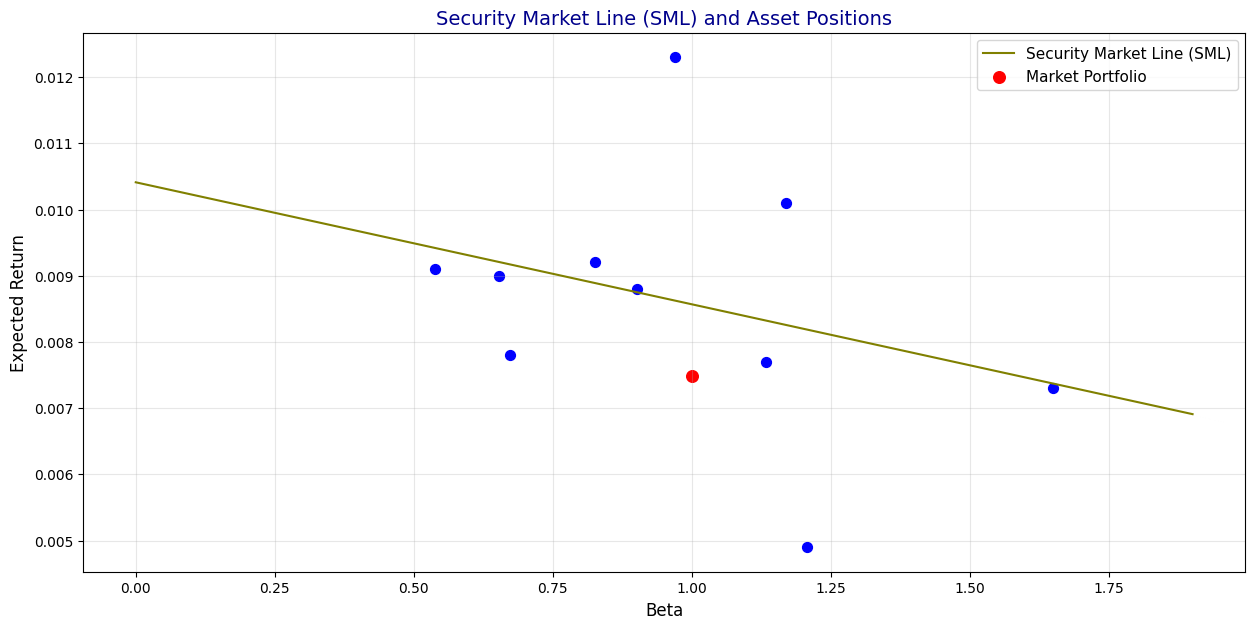

In [21]:
beta_range = np.arange(0, 2, 0.1) # set horizontal values of beta displayed
sml_int, sml_slope, sml = (sml_calc_and_plot(
    sml_df, 0.13/100, beta_range, market_series, ret='Return', beta='BETA'))

In [22]:
sml_int

0.0104

In [23]:
sml_slope

-0.0018

* My gmail is binhnguyen.ibm@gmail.com
* For advance and complex models in practice, we can discuss for collaboration.
* Thank you.